<a href="https://colab.research.google.com/github/Mathis1993/DCGAN/blob/master/DCGAN_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to this small workshop on GANs. Before we really start, we have to organize our hardware (thanks, Google!) and access to our data.

## Choose Hardware Accelerator

To run on GPU, from the menu, select
* Runtime -> Change Runtime Type --> Hardware Accelerator --> GPU


## Mount Google Drive

Before starting, we want to mount our Google Drive to have access to our data in colab.

This is where our data is located. The folder should be shared with everybody. If that's not the case, the data can be found [here](https://drive.google.com/open?id=19zewI-wxU-EACyo5yWyrIErzlj-sX-1j) to be added to your drive. The full dataset can be found [here](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg).

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, specify the directory holding our data.

In [0]:
path =  "/content/drive/My Drive/"

Now, we can get started with our Deep Convolutional Generative Adversarial Network (DCGAN).

## DCGAN

We want to create a network through which we are able to generate images of faces that look as real as possible. Or, put differently, we want a network to learn the distribution of face data, to be able to sample new data (new faces) from that distribution.

This tutorial is mainly inspired by [this official pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) by Nathan Inkawhich.

### Imports

In [0]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

#Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed) #set randoms' random seed
torch.manual_seed(manualSeed) #set pytorch's random seed

Random Seed:  999


### Parameters

The hyperparameters' values (set here and in the model section) are best practice recommendations from [this paper](https://arxiv.org/pdf/1511.06434.pdf).

In [0]:
#Root directory for dataset
dataroot = path + "data_workshop"

#Number of workers for dataloader
workers = 8

#size using a transformer.
image_size = 64

#Batch size during training
batch_size = 128

#Number of training epochs
num_epochs = 30

#Learning rate for optimizers
lr = 0.0002

#Beta1 hyperparam for Adam optimizers
beta1 = 0.5

#Whether to use GPU
gpu = True

## GPU device

In order to use the GPU Google is offering to us, we create a pytorch device. When creating a tensor or a model later, we can do that on this device or push the object to this device. Like that, all the calculations can easily run on the GPU.

In [0]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and gpu) else "cpu")
print(device)

cuda:0


### Data

Firts, we specify the structure of our dataset. We set our image folder up in way that we can use it with Pytorch's ImageFolder Dataset-class: In a directory, we have one or more subdirectories containing the images.
We can specify transforms here, that are called when the data is loaded. Here, we resize the images to have 64x64 pixels, we declare them to be tensors and we normalize the range of their values (which orignially are at [0,1] to [-1,1], as this is the range the generator will output later.

In [0]:
#Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

Next, we can feed the dataset into an instance of the DataLoader-class, specifying the batch_size, if batches should be drawn randomly and how many cores should work on retrieving batches in parallel.

In [0]:
#Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

How many batches are loaded? It might take a while until all files from the shared data folder "arrived" in our drive. We have 5000 images, so with a batch size of 128 that should sum up to around 40 batches. If it's less, rerun the dataloader after some time.

In [0]:
len(dataloader)

40

Our dataloader is iterable, so we can call next() on it to retrieve a batch of randomly selected images. We want to plot 64 of these in a grid (conveniently done with pytorch's make_grid-function) to take a peek at our data. Note that we have to swap the tensors' axes (that hold the image data) for plotting. Pytorch usually represents image data as (n_channels x height x width) while numpy does as (height x width x n_channels).
Also, as currently our images are in a range of [-1,1], which pyplot can't work with, we need to normalize them to [0,1] again.

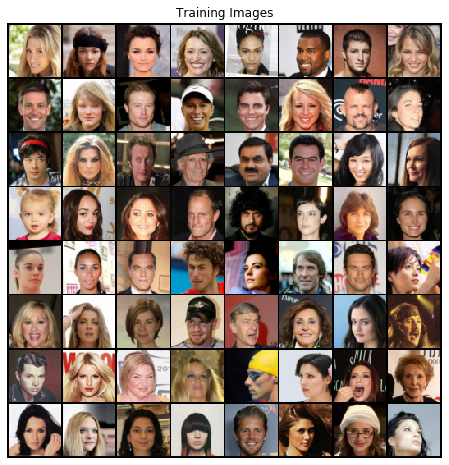

In [0]:
#Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
#dataloader gives tuple of (data-tensor, target-tensor) with targets defaulting to 0 (as we only used one subfolder)
#make grid on gpu, then push it to cpu so numpy can use it
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0))) #normalize from [-1,1] to [0,1] again

### Weight Initialization

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Models
We have two physical models:
1. The **discriminator**: A regular CNN taking a batch of images as an input, and classifying for each image if it believes it to be real or not. It outputs the probability of an image being real (in its opinion).

2. The **generator**: Into this model, we feed a vector of random numbers (drawn from the standard normal distribution). These are transformed into a 3x64x64 color image. We want this image to look real (we want the generator to capture the images' distribution).

#### Discriminator

The discriminator is a classical classifier. We can imagine its layers processing the 3x64x64 input images to become a prediction ranging from 0-1 like this:

<br>

<img src="https://drive.google.com/uc?export=view&id=1y0MIUVDW9kwOeDItmGdK9LZL8vFumoCO" width=700/>

<br>
<br>

We can calculate how a convolution changes its input with the following formula:

$\mathbf O = (\frac{I - K + 2*P}{S}) + 1$
- O = Output dimensions
- I = Input dimensions
- K = Kernel size
- P = Padding
- S = Stride

##### Task 1: Specify the discriminator model

The discriminator should have 4 convolutional layers, each with 
- a kernel size of 4x4
- padding of 1 pixel
- a stride of 2

The first layer of course takes 3 channels and outputs 64 channels. The second layer outputs 128 channels

If you get stuck, you can take a look here (**Link to Model-Notebook, change models there**)

**corrected discriminator image, commit and push that**

In [0]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    
    ##Your code here

  def forward(self, x):
    
    ##Your code here

    return x

#### Generator

The generator goes the other way round: It takes as input a random vector from latent space and upsamples it to be an image of 3x64x64, like this:

<br>

<image src="https://drive.google.com/uc?export=view&id=1R6krNT2BMjeFctIX3Mok4zOyeglt9HXK" width=700>

<br>

In [0]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()
    
    self.convT_block1 = nn.Sequential(
        #100 x 1 x 1
        nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.convT_block2 = nn.Sequential(
        #512 x 4 x 4
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.convT_block3 = nn.Sequential(
        #256 x 8 x 8
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.convT_block4 = nn.Sequential(
        #128 x 16 x 16
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.convT_block5 = nn.Sequential(
        #64 x 32 x 32
        nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )
        #3 x 64 x 64

  def forward(self, x):
    x = self.convT_block1(x)
    x = self.convT_block2(x)
    x = self.convT_block3(x)
    x = self.convT_block4(x)
    x = self.convT_block5(x)
    return x

#### Instantiate Models

This will also give an overview of the models.

Discriminator

In [0]:
discriminator = Discriminator().to(device)

#initialize weights
discriminator.apply(weights_init)

Discriminator(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), st

Generator

In [0]:
generator = Generator().to(device)

#initialize weights
generator.apply(weights_init)

Generator(
  (convT_block1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convT_block5): Sequential(
    (0): ConvTranspose2d(

### Loss Function

We are using Binary Cross Entropy Loss here.

In [0]:
criterion = nn.BCELoss()

### Optimizers

Adam optimizers with best-practice parameters.

In [0]:
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Let's loop over our dataset a couple of times. Each time we train the discriminator on a batch of real and a batch of fake data. The generator is trained by using the discriminator's output when fed fake data.

In [0]:
#To track how the latent space is given sense
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

#To track progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
#For each epoch
for epoch in range(num_epochs):
    
    #For each batch in the dataloader
    for i, data in enumerate(dataloader, 0): #at what index to start

      #extract real images from list holding data and nonsense targets
      #and push to device
      data_real = data[0].to(device)

      #calculate acutal batch size (in the last batch per epoch, it could be != our determined batch_size)
      b_size = data_real.size(0)

      #targets
      label_real = torch.full(size=(b_size,), fill_value=1).to(device)
      label_fake = torch.full(size=(b_size,), fill_value=0).to(device)

      #push everything to gpu
      if gpu:
        if torch.cuda.is_available():
          data_real.cuda()
          label_real.cuda()
          label_fake.cuda()

      #train discriminator on real batch
      #zero gradient buffer
      discriminator.zero_grad()
      #forward pass
      output_d_real = discriminator(data_real).view(-1)
      #calculate loss
      loss_d_real = criterion(output_d_real, label_real)
      #backward pass
      loss_d_real.backward()

      #train discriminator on fake batch
      #Generate batch of latent vectors
      z = torch.randn(b_size, 100, 1, 1, device=device)
      #Generate fake image batch with the generator
      data_fake = generator(z)
      output_d_fake = discriminator(data_fake.detach()).view(-1) #detach fake images from generator
      loss_d_fake = criterion(output_d_fake, label_fake)
      loss_d_fake.backward()

      #summarize loss 
      loss_d = loss_d_real + loss_d_fake
      #update discriminator weights
      optimizerD.step()

      #train generator
      generator.zero_grad()
      #as we just updated the discriminator, pass the fake data through it again
      output_g = discriminator(data_fake).view(-1)
      #use real labels here!
      loss_g = criterion(output_g, label_real)
      loss_g.backward()
      #update generator weights
      optimizerG.step()

      #track losses
      G_losses.append(loss_d.item())
      D_losses.append(loss_g.item())

      #How did D and G perform in discriminating/generating images?
      D_x = output_d_real.mean().item() * 100
      D_G_z1 = output_d_fake.mean().item() * 100
      D_G_z2 = output_g.mean().item() * 100

      #print information
      if (iters % 20 == 0):
        print("Epoch [{:02d}/{:02d}], Batch [{:02d}/{:02d}], Iteration {:04d}, D_loss: {:06.3f}, G_loss: {:06.3f}. Real images recognized as real: {:05.2f}%. Fake images fooled by: {:05.2f}% and {:05.2f}%.".format(epoch+1, num_epochs, i+1, len(dataloader), iters+1, loss_d.item(), loss_g.item(), D_x, D_G_z1, D_G_z2))

      #save generated images
      if (iters % 40 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      iters += 1

Starting Training Loop...
Epoch [01/30], Batch [01/40], Iteration 0001, D_loss: 02.001, G_loss: 04.244. Real images recognized as real: 47.95%. Fake images fooled by: 59.83% and 02.39%.
Epoch [01/30], Batch [21/40], Iteration 0021, D_loss: 00.280, G_loss: 15.272. Real images recognized as real: 97.81%. Fake images fooled by: 20.83% and 00.00%.
Epoch [02/30], Batch [01/40], Iteration 0041, D_loss: 00.745, G_loss: 27.091. Real images recognized as real: 74.49%. Fake images fooled by: 00.00% and 00.00%.
Epoch [02/30], Batch [21/40], Iteration 0061, D_loss: 00.561, G_loss: 26.597. Real images recognized as real: 78.59%. Fake images fooled by: 00.00% and 00.00%.
Epoch [03/30], Batch [01/40], Iteration 0081, D_loss: 00.436, G_loss: 07.410. Real images recognized as real: 85.54%. Fake images fooled by: 13.64% and 00.13%.
Epoch [03/30], Batch [21/40], Iteration 0101, D_loss: 00.844, G_loss: 05.408. Real images recognized as real: 63.01%. Fake images fooled by: 00.78% and 03.09%.
Epoch [04/30],

### Evaluation

Plot the discriminator's and generator's training losses over the iterations.

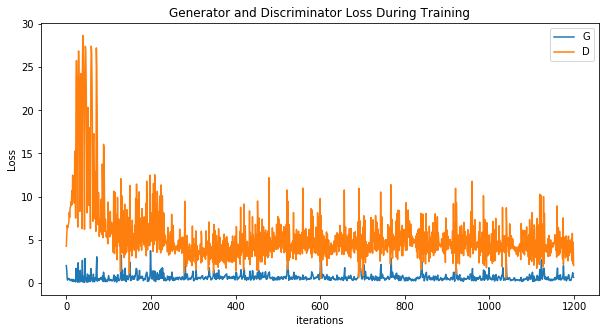

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Let's take a look at a batch of real and a batch of generated images. The generated images were generated in the last training epoch.

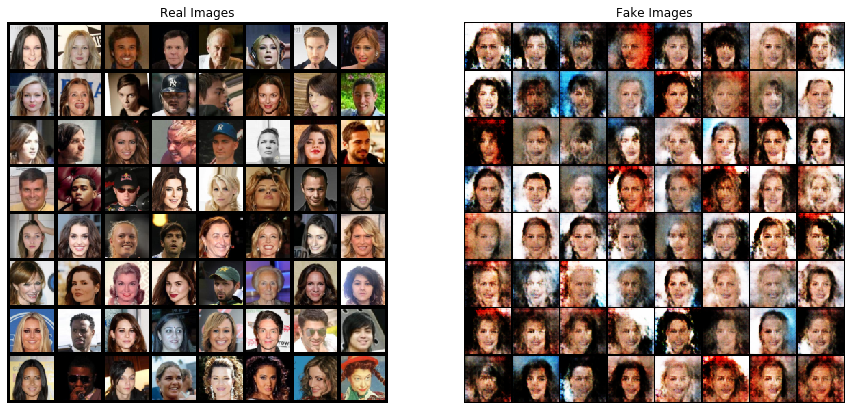

In [0]:
#Get batch of images
real_batch = next(iter(dataloader))

#Plot real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

#Plot fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
plt.show()

Generate some more images by feeding points from latent space into the generator.

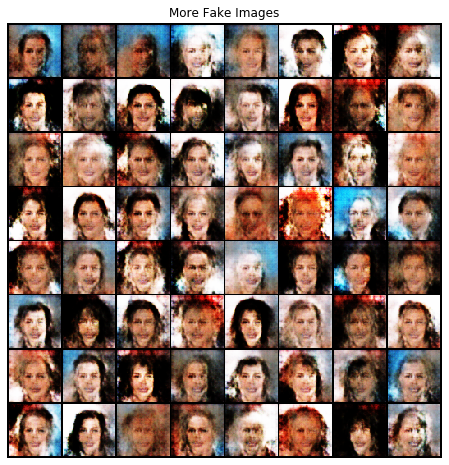

In [0]:
z = torch.randn(64, 100, 1, 1, device=device)
with torch.no_grad():
  fake = generator(z).detach().cpu()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("More Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))

Let's visualize the progress our GAN made in a nice animation.

In [0]:
#Animation in output is so big that colab takes too long to save, so don't output it right now
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
#HTML(ani.to_jshtml())